<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Advanced_Langchain_RAG_Implementaion_using_Mistral_AI_and__Embed_Caching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU langchain Faiss-gpu tiktoken sentence-transformers

In [2]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-p2a9vft8
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-p2a9vft8
  Resolved https://github.com/huggingface/transformers to commit 897a826d830e8b1e03eb482b165b5d88a7a08d5f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -qU trl Py7zr auto-gptq optimum

In [4]:
# Base ctransformers with CUDA GPU acceleration
! pip install ctransformers[cuda]

In [5]:
!pip install PyPdf

In [6]:
pip install rank_bm25

## Load Dataset

## Data Parsing using langchain

In [7]:
from langchain.document_loaders import PyPDFLoader
#
esops_loader = PyPDFLoader("/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf").load()
print(f"len of documents in :{len(esops_loader)}")
#

len of documents in :44


## Create Managebale pieces of text by using RecursiveCharacterTextSplitter to create chunks for reviews

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
#
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500,
                                      chunk_overlap=100,
                                      length_function=len,)
#
esops_documents = text_splitter.transform_documents(esops_loader)
print(f"number of chunks in barbie documents : {len(esops_documents)}")


number of chunks in barbie documents : 45


## Create Vectorstore

* Here we will leverage a CacheBackedEmbeddings to prevent us from reembedding similar queries over and over again.
* Structured documents will be passed into a usesful format for querying ,retrieving and use in LLM application
* here we will use FAISS(Facebook AI similarity search) as the vectorstore.

In [9]:
from langchain.embeddings import CacheBackedEmbeddings,HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.retrievers import BM25Retriever,EnsembleRetriever

In [10]:
store = LocalFileStore("./cache/")
#embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'
#changed the embedding model
embed_model_id = 'BAAI/bge-small-en-v1.5'
core_embeddings_model = HuggingFaceEmbeddings(model_name=embed_model_id)
embedder = CacheBackedEmbeddings.from_bytes_store(core_embeddings_model,
                                                  store,
                                                  namespace=embed_model_id)

## Create Vectorstore

In [11]:
vectorstore = FAISS.from_documents(esops_documents,embedder)

## Create Sparse Embedding

In [12]:
bm25_retriever = BM25Retriever.from_documents(esops_documents)

In [48]:
bm25_retriever.k=5

## Embed Query - bge-small-en-v1.5

In [ ]:
query = "What is the early stage grant for CTO in ESOP alocation?"
embedding_vector = core_embeddings_model.embed_query(query)
len(embedding_vector)

384

## Retrieve passages from the vectorstore that are similar to the query

In [ ]:
docs = vectorstore.similarity_search_by_vector(embedding_vector,k=15)

## Retrieved - content -  bge-small-en-v1.5 embedding

In [ ]:
for page in docs:
  print(page.page_content)
  print("\n")

Table of Contents  
Part I: Intro to Options Plans  
•What is an ESOP?  
•What is an Option?  
•Lifecycle of a Startup ESOP  
•Common Terms in an Options Package  
•Why Issue Options to Employees ? 
–A Defining Characteristic of Startup Culture  
–A Necessary Part of the Capital Structure  
•When to Create an ESOP ? 
•Communicating Options to Employees: % versus $ 
 
Part II: How Much to Grant  
•Two Approaches  
•The Top -Down Process  
–1. How Much Equity to Set Aside in the ESOP ? 
–2. A Typical Distribution Schedule  
•The Bottom -Up Process  
–1. Segment Your Human Resources  
–2. Establish Pay Multipliers for Each Role 
–3. Determine the Dollar Value of the Options Grant  
–4. Determine the Current Share Price  
–5. Calculate the Options Grant  
–An Example: Hiring a CTO  
•Important Takeaways  Part III : The Fine Print – Terms  
•Strike Price  
•Vesting Schedule  
•The Cliff  
–Example: Standard Vesting w/ a Cliff 
•Vesting in a Liquidity Event  
•Exercising Options  
•Tax Consi

## Check to see  how much time CacheBackedEmbeddings pattern saves us

In [ ]:
%%timeit -n 1 -r 1
query = "What is the early stage grant for CTO in ESOP alocation?"
#
embedding_vector = core_embeddings_model.embed_query(query)
docs = vectorstore.similarity_search_by_vector(embedding_vector,k=15)

20 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Setup Ensemble Retriever (Hybrid Search)

In [49]:
faiss_retriever = vectorstore.as_retriever(search_kwargs={"k":5})
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever,faiss_retriever],
                                       weights=[0.5,0.5])

## Building a retrieval chain

#### Initialize LLM using a quantized GPTQ Model

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-32g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="gptq-8bit-32g-actorder_True")
#
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


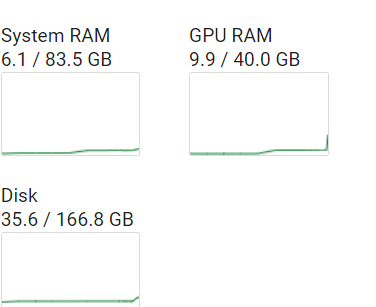

In [51]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.1,
    top_p=0.95,
    top_k=40,
    repetition_penalty=1.1
)

In [53]:
from langchain.llms import HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=pipe)

## Caching

In [18]:
import langchain
from langchain.cache import InMemoryCache
langchain.llm_cache = InMemoryCache()

## Setup Retrieval chain - without Hybrid Search

In [70]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
#
handler = StdOutCallbackHandler()
#
qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever = vectorstore.as_retriever(search_kwargs={"k":5}),
    #retriever = vectorstore.as_retriever(),
    #retriever = ensemble_retriever,
    callbacks=[handler],
    return_source_documents=True
)

## Provide the user query

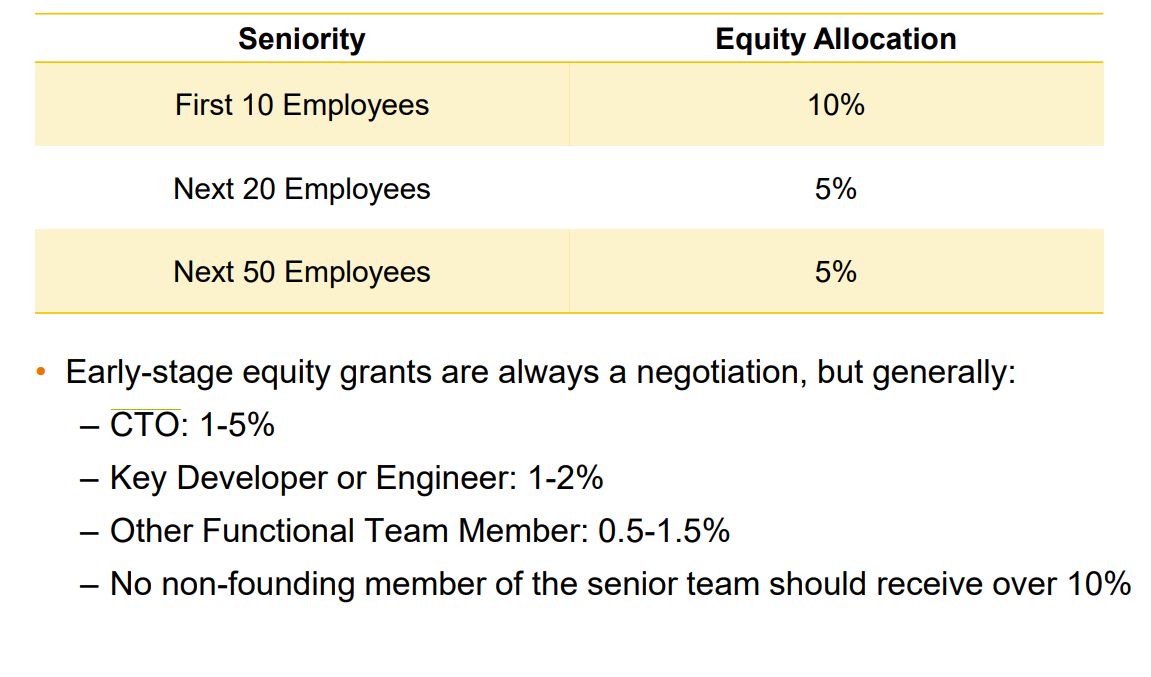

In [71]:
%%time
query = "What is the early stage grant for CTO in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")




> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The early stage grant for CTO in ESOP allocation is 1-5%.
Source Documents : 
 [Document(page_content='Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calculate the Options Grant  \n–An Example: Hiring a CTO  \n•I

In [72]:
%%time
query = "What is the early stage grant for Key Developer or Engineer in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The early stage grant for a Key Developer or Engineer in ESOP allocation depends on the company's specific needs and goals. It may vary based on factors such as the role's importance to the company, the individual's experience and performance, and the company's overall funding status. However, it is important to note that ESOPs are typically used to incentivize long-term commitment and retention, rather than short-term performance. Therefore, the grant should be structured in a way that aligns with the company's long-term objectives and values.
Source Documents : 
 [Document(page_content='Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESO

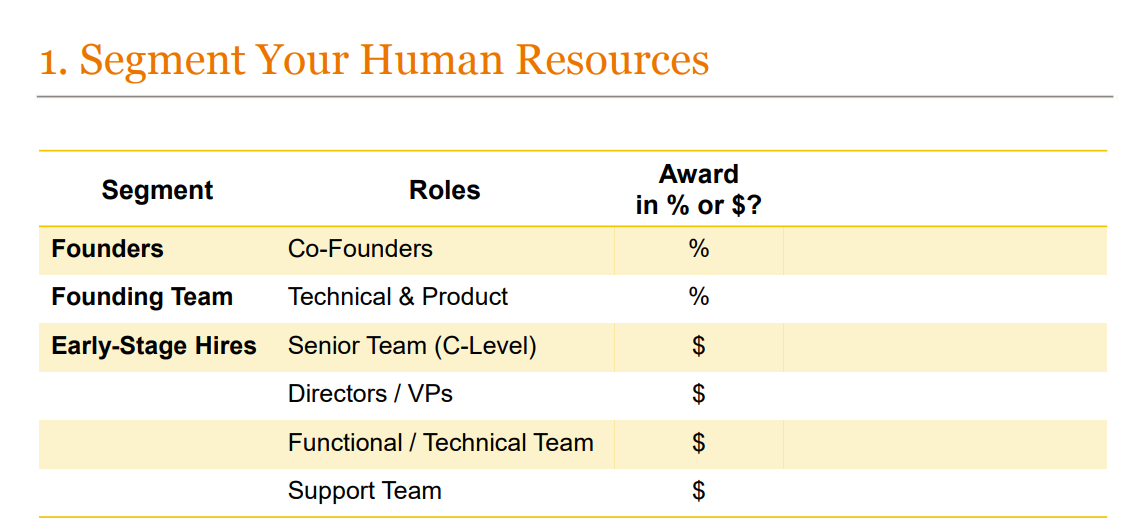

In [22]:
%%time
query = "What are the segments in human resources?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Segments in human resources refer to groups of employees based on their roles or responsibilities within a company. These segments help companies to determine the pay and benefits that are appropriate for each group, as well as to track the performance and productivity of different areas of the organization. In the context of options grants, segments are used to establish standardized pay multipliers for each role, which helps to ensure that employees are compensated fairly and consistently based on their contributions to the company.
Source Documents : 
 [Document(page_content='1. Segment Your Human Resources  \nSegment  Roles  Award  \nin % or $?  \nFounders  Co-Founders  % \nFounding Team  Technical & Product  % \nEarly -Stage Hires  Senior Team  (C-Level)  $ \nDirectors / VPs  $ \nFunctional / Technical Team  $ \nSupport Team  $ \n•Think about the early -stage team in three segments  \n–Founders : the 

In [73]:
%%time
query = "What is the early stage grant for Developer or Engineer in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The early stage grant for a Developer or Engineer in an ESOP allocation depends on several factors such as the company's stage, the role of the employee, and the company's overall equity allocation strategy. However, based on industry standards, a typical early stage grant for a Developer or Engineer may range from 0.1% to 0.5% of the fully diluted valuation of the company. It's important to note that this is just a rough estimate and the actual grant amount may vary depending on the specific circumstances of the company and the employee.
Source Documents : 
 [Document(page_content='Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n

In [74]:
%%time
query = "What is the early stage grant for non founding member of senior team in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Non-founding members of the senior team typically receive between 1% and 2% of the equity allocation in an ESOP.
Source Documents : 
 [Document(page_content='Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. How Much Equity to Set Aside in the ESOP ? \n–2. A Typical Distribution Schedule  \n•The Bottom -Up Process  \n–1. Segment Your Human Resources  \n–2. Establish Pay Multipliers for Each Role \n–3. Determine the Dollar Value of the Options Grant  \n–4. Determine the Current Share Price  \n–5. Calcula

In [75]:
%%time
query = "What is the early stage grant for Functional Team member of senior team in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The typical distribution schedule for early stage equity grants is as follows: First 10 Employees - 10%, Next 20 Employees - 5%, Next 50 Employees - 5%. For Functional Team members of the senior team, the typical allocation is between 0.5% and 1.5%. However, it's important to note that these are general guidelines and the actual allocation will depend on various factors specific to the company and its needs.
Source Documents : 
 [Document(page_content='Table of Contents  \nPart I: Intro to Options Plans  \n•What is an ESOP?  \n•What is an Option?  \n•Lifecycle of a Startup ESOP  \n•Common Terms in an Options Package  \n•Why Issue Options to Employees ? \n–A Defining Characteristic of Startup Culture  \n–A Necessary Part of the Capital Structure  \n•When to Create an ESOP ? \n•Communicating Options to Employees: % versus $ \n \nPart II: How Much to Grant  \n•Two Approaches  \n•The Top -Down Process  \n–1. H

In [25]:
%%time
query = "What is the document about?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  This document appears to be a presentation about Employee Stock Options Plans (ESOPs) for startups. It covers topics such as creating an ESOP, communicating options to employees, and using an options model to understand the long-term effects of this program. It also discusses tax considerations and legal advice.
Source Documents : 
 [Document(page_content='THE FINE PRINT – TERMS  Part III', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 25}), Document(page_content='RESOURCES & FURTHER \nREADING  Part V', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 40}), Document(page_content='Options Modeling – Overview  \n•Creating an ESOP has lasting implications on startup capital structure  \n•While the guidelines provided in this presentation offer a roadmap to \nimplementing an options plan, it can also be helpful to buil

## LLM Caching applied as the context of the question is the same.

In [26]:
%%time
query = "Please summarize what is the document about?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  This document appears to be about employee stock options plans for startups, specifically focused on the fine print of the terms involved. It covers topics such as strike price, vesting, cliff periods, expiration dates, number of shares, and more. The document also offers guidance on how to create an options model to understand the long-term effects of an options program on a company's capital structure.
Source Documents : 
 [Document(page_content='THE FINE PRINT – TERMS  Part III', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 25}), Document(page_content='RESOURCES & FURTHER \nREADING  Part V', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 40}), Document(page_content='INTRO TO OPTIONS PLANS  Part I', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 2}), Document(page

In [27]:
%%time
query ="How to Determine the Dollar Value of the Options Grant?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")




> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Options can be communicated either as (1) a percentage of ownership in the company, or (2) a dollar value based on the current valuation; we encourage the latter when possible.
Source Documents : 
 [Document(page_content='5. Calculate the Options Grant  \nOptions Grant  \n(Number of Shares)  = Dollar Value  \nof Options Grant  \nCurrent Share Price', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 22}), Document(page_content='3. Determine the Dollar Value of the Options Grant  \nEmployee  \nBase Salary  = x Options  \nMultiplier  Dollar Value  \nof Options Grant  Base Salary as negotiated with \nthe employee at the time of hire \nor promotion  \nOptions Multiplier is decided \nbased on the employee’s role in \nthe HR segmentation schedule', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 20}), Document(page_content=

In [ ]:
%%time
query ="How to Determine the Dollar Value of the Options Grant?Please give the formulae."
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
 

There are different ways to determine the dollar value of an options grant. One way is to use the Black-Scholes model, which takes into account factors such as the stock price, strike price, time to expiration, volatility, and risk-free interest rate. However, this model requires complex calculations and may not be suitable for small companies or startups.

Another way is to use a simplified formula based on the current stock price and the options multiplier. For example, if an employee is granted 100 options with a strike price of $10 and an options multiplier of 0.5x, the dollar value of the options grant would be:

Dollar Value = Number of Options x Options Multiplier x Current Stock Price

So, in this case, the dollar value of the options grant would be:

Dollar Value = 100 x 0.5x x $10 = $5,000

This formula assumes that the stock price remains constant over the life of the options grant. If the stoc

## Setup Retrieval chain - with Hybrid

In [76]:
##Ensemble Retriever
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
#
handler = StdOutCallbackHandler()
#
qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever = ensemble_retriever,
    callbacks=[handler],
    return_source_documents=True
)

In [55]:
%%time
query = "Who are the different stakeholders for granting ESOPS asnd their respective share percentage according to the context in the document?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  According to the context in the document, the different stakeholders for granting ESOPs are founders and early investors, management and the board of directors, and employees. The share percentage for each stakeholder varies depending on the specific circumstances of the company. For example, founders and early investors typically set aside a percentage of shares to be granted to future employees, while management and the board of directors issue these shares to employees as options packages. Employees receive all of their options upfront, but the company maintains a right to force forfeit that diminishes over time through a process called vesting.
Source Documents : 
 [Document(page_content='Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 0}), Document(page_content='Communicatin

In [56]:
%%time
query = "What is the early stage grant for Key Developer or Engineer in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The early stage grant for Key Developer or Engineer in ESOP allocation is typically between 1-2%.
Source Documents : 
 [Document(page_content='When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed without an \nESOP; the benefit to doing so is that \nseed investors then share in the dilution  \nEarly -VC The first true VC round. Investors will \nrequire an ESOP in place. New hires \nwill be seek large equity grants.  ESOP must be created  (to appease \ninvestors and to serve as a guideline for \nthe si

In [57]:
%%time
query = "What is the early stage grant for Developer or Engineer in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The typical distribution schedule for ESOP allocation for developers or engineers is 1-2%.
Source Documents : 
 [Document(page_content='When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed without an \nESOP; the benefit to doing so is that \nseed investors then share in the dilution  \nEarly -VC The first true VC round. Investors will \nrequire an ESOP in place. New hires \nwill be seek large equity grants.  ESOP must be created  (to appease \ninvestors and to serve as a guideline for \nthe size of n

* In the above cache Caching is applied

In [58]:
%%time
query = "What is the early stage grant for CTO in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The early stage grant for CTO in ESOP allocation is 1-5%.
Source Documents : 
 [Document(page_content='When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed without an \nESOP; the benefit to doing so is that \nseed investors then share in the dilution  \nEarly -VC The first true VC round. Investors will \nrequire an ESOP in place. New hires \nwill be seek large equity grants.  ESOP must be created  (to appease \ninvestors and to serve as a guideline for \nthe size of new -hire options grants)  \nLate-

In [59]:
%%time
query = "What is the early stage grant for non founding member of senior team in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Non-founding members of the senior team typically receive between 1 -2% of the company in early stage equity grants.
Source Documents : 
 [Document(page_content='2. A Typical Distribution Schedule  \nSeniority  Equity Allocation  \nFirst 10 Employees  10% \nNext 20 Employees  5% \nNext 50 Employees  5% \n•Early -stage equity grants are always a negotiation, but generally:  \n–CTO: 1 -5% \n–Key Developer or Engineer: 1 -2% \n–Other Functional Team Member: 0.5 -1.5%  \n–No non -founding member of the senior team should receive over 10%', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 16}), Document(page_content='1. How Much Equity to Set Aside in the ESOP?  \n•Founders  are top managers \nwith functional roles that are \nnot redundant  \n•DNA  of the company is in a \nnon-technical industry; no \ntechnology emphasis  \n•Geographic focus  is on a \nregion that is

In [60]:
%%time
query = "What is the early stage grant that no non founding member of senior team in ESOP should be allocated?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  No non founding member of the senior team should receive over 10%
Source Documents : 
 [Document(page_content='When to Create an ESOP?  \nStage  Considerations  Takeaway  \nPre-seed  Founders focused on traction  (often too \nbusy for an ESOP).  Key employees are \ngiven equity/options on an ad hoc basis  ESOP  not necessary, but it can be \nhelpful to sanity check how much equity \nyou are giving away to early hires  \nSeed  First outside financing round. Investors \neither angel or institutional; institutional \ninvestors will require an ESOP  Seed rounds can be closed without an \nESOP; the benefit to doing so is that \nseed investors then share in the dilution  \nEarly -VC The first true VC round. Investors will \nrequire an ESOP in place. New hires \nwill be seek large equity grants.  ESOP must be created  (to appease \ninvestors and to serve as a guideline for \nthe size of new -hire options grants) 

In [61]:
%%time
query = "How to Determine the Dollar Value of the Options Grant?Please give the formulae."
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  To determine the dollar value of the options grant, you need to multiply the number of shares granted by the current share price. For example, if an employee is granted 1000 shares and the current share price is $10, then the dollar value of the options grant would be $10,000.
Source Documents : 
 [Document(page_content='3. Determine the Dollar Value of the Options Grant  \nEmployee  \nBase Salary  = x Options  \nMultiplier  Dollar Value  \nof Options Grant  Base Salary as negotiated with \nthe employee at the time of hire \nor promotion  \nOptions Multiplier is decided \nbased on the employee’s role in \nthe HR segmentation schedule', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 20}), Document(page_content='5. Calculate the Options Grant  \nOptions Grant  \n(Number of Shares)  = Dollar Value  \nof Options Grant  \nCurrent Share Price', metadata={'source': '

In [62]:
%%time
query = "How to Determine the Dollar Value of the Options Grant?Please give the formulae."
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  To determine the dollar value of the options grant, you need to multiply the number of shares granted by the current share price. For example, if an employee is granted 1000 shares and the current share price is $10, then the dollar value of the options grant would be $10,000.
Source Documents : 
 [Document(page_content='3. Determine the Dollar Value of the Options Grant  \nEmployee  \nBase Salary  = x Options  \nMultiplier  Dollar Value  \nof Options Grant  Base Salary as negotiated with \nthe employee at the time of hire \nor promotion  \nOptions Multiplier is decided \nbased on the employee’s role in \nthe HR segmentation schedule', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 20}), Document(page_content='5. Calculate the Options Grant  \nOptions Grant  \n(Number of Shares)  = Dollar Value  \nof Options Grant  \nCurrent Share Price', metadata={'source': '

In [63]:
%%time
query ="What is the document about?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The document is about Employee Stock Options Plans (ESOPs) and how they can be used in startups. It explains what an ESOP is, how to determine the current share price, and how options can be used to bring in founding team members, recruit and compensate early employees, and allow later employees to share in the company's long-term upside. The document also discusses the importance of appropriate use of these securities based on local regulatory and tax considerations, and provides an overview of options modeling to understand the long-term effects of an options plan.
Source Documents : 
 [Document(page_content='THE FINE PRINT – TERMS  Part III', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 25}), Document(page_content='What is an ESOP?  \n•An Employee Stock Options Plan (ESOP)  \n \n•An allocation  of shares that will be granted to employees in the future \ni

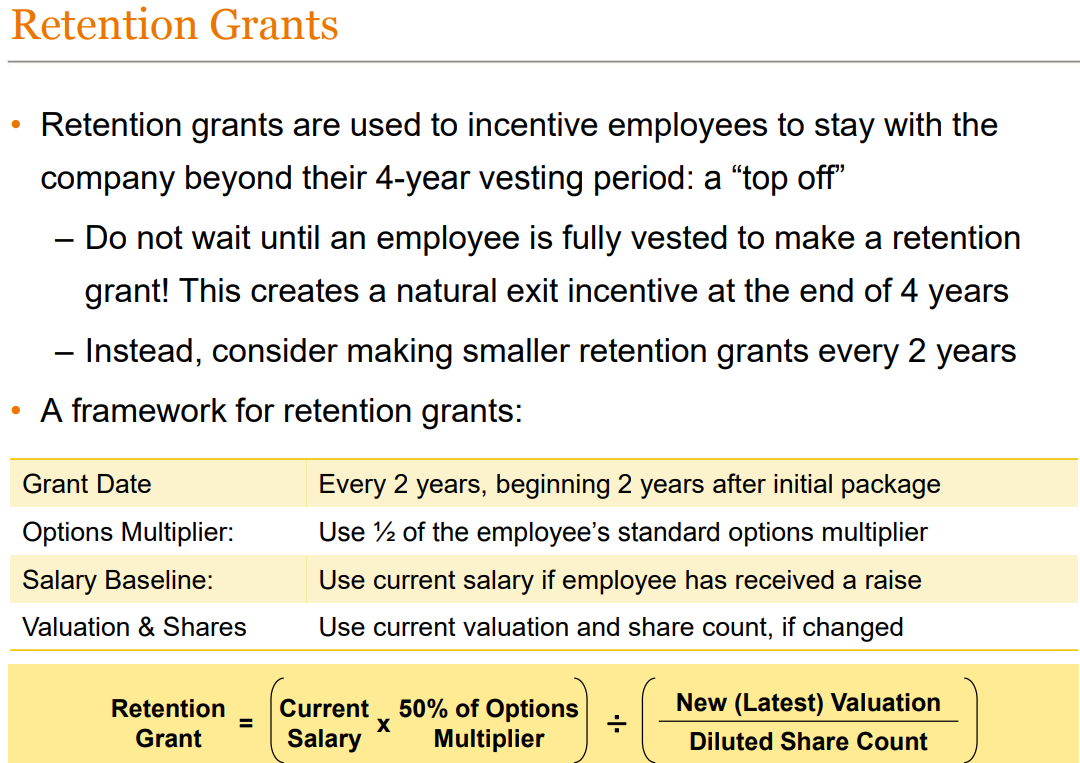

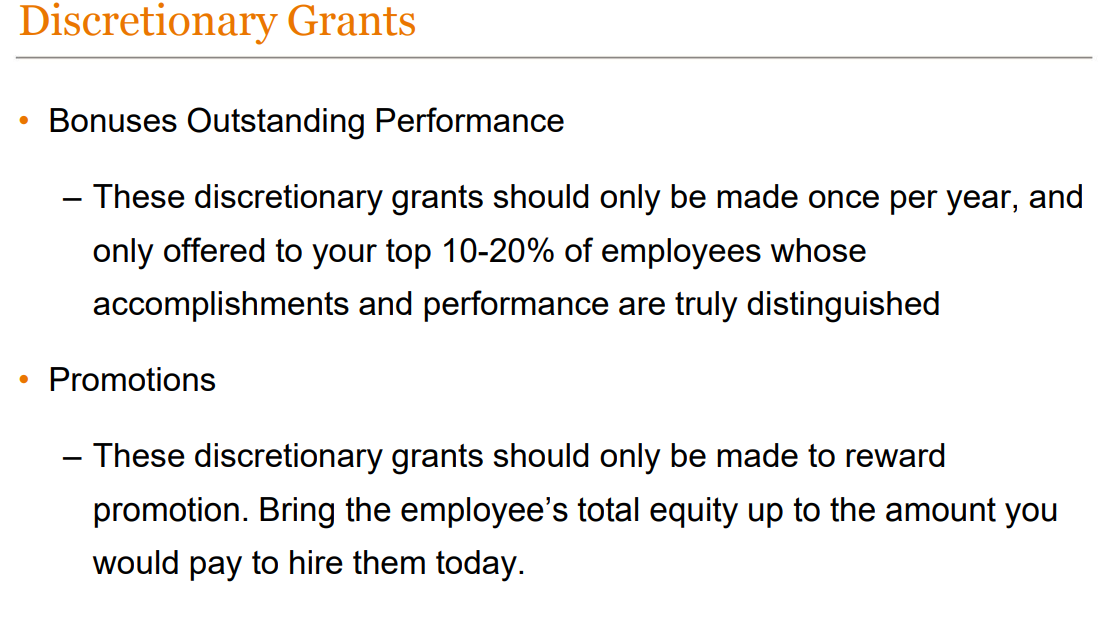

In [64]:
%%time
query ="What is the difference between Retention grants and Discretionary Grants?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Retention grants are used to incentivize employees to stay with the company beyond their 4-year vesting period, while Discretionary grants are used to reward outstanding performance and promotions.
Source Documents : 
 [Document(page_content='Discretionary Grants  \n•Bonuses Outstanding Performance  \n–These discretionary grants should only be made once per year, and \nonly offered to your top 10 -20% of employees whose \naccomplishments and performance are truly distinguished  \n•Promotions  \n–These discretionary grants should only be made to reward \npromotion. Bring the employee’s total equity up to the amount you \nwould pay to hire them today.', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 36}), Document(page_content='Retention Grants  \n•Retention grants are used to incentive employees to stay with the \ncompany beyond their 4 -year vesting period: a 

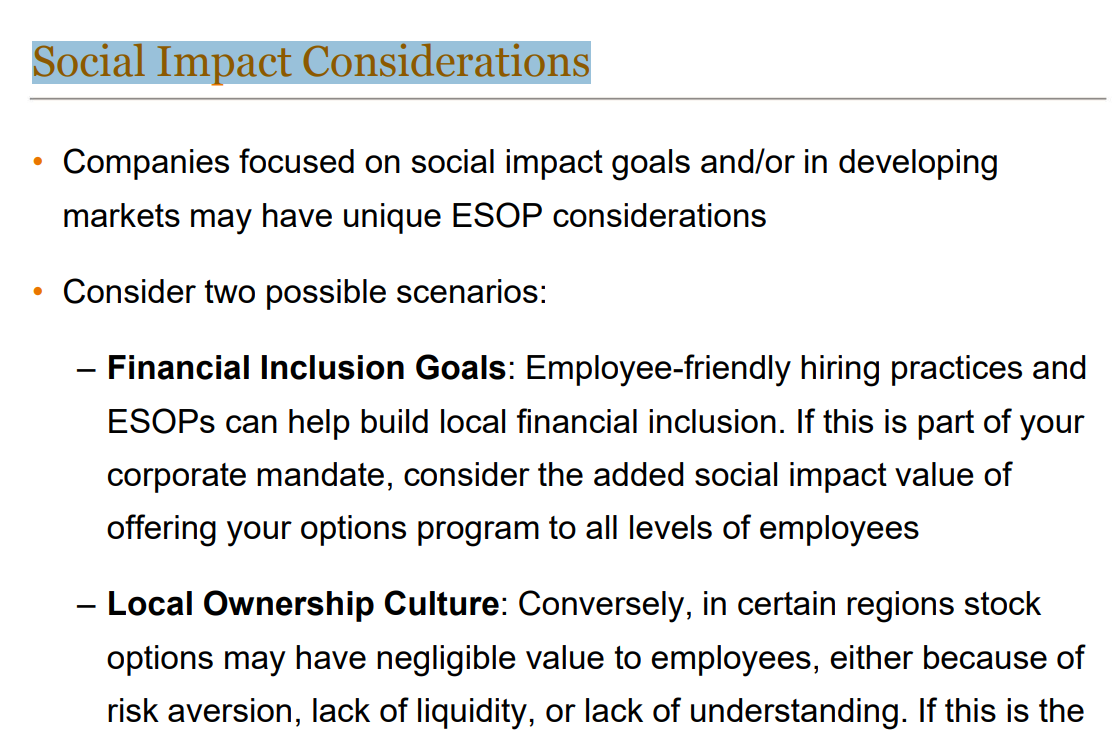

In [65]:
%%time
query = "What are the Social Impact Considerations for Esops?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  Companies focused on social impact goals and/or in developing markets may have unique ESOP considerations. Two possible scenarios are Financial Inclusion Goals and Local Ownership Culture. For Financial Inclusion Goals, employee-friendly hiring practices and ESOPs can help build local financial inclusion. If this is part of your corporate mandate, consider the added social impact value of offering your options program to all levels of employees. On the other hand, in certain regions, stock options may have negligible value to employees, either because of risk aversion, lack of liquidity, or lack of understanding. If this is the case, it is not worth extensively offering options to employees who would rather be paid in cash.
Source Documents : 
 [Document(page_content='Social Impact Considerations  \n•Companies focused on social impact goals and/or in developing \nmarkets may have unique ESOP considerations

In [66]:
query = "according to Fred Wilson what is the necessary part of Capital Structure?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.
Response generated : 
  According to Fred Wilson, venture capitalists require ESOPs as a prerequisite to closing a deal.
Source Documents : 
 [Document(page_content="A Necessary Part of the Capital Structure  \n•Venture capitalists require ESOPs . For many VCs, establishing a \nstock option pool is a prerequisite to closing a deal  \n–In an industry where options are ubiquitous, startups are compelled \nto offer options packages to compete for top talent with other \nventure -backed companies  \n–When operating budgets are tight, competitive compensation \npackages may not be possible; options can be used to incentivize \nemployees instead of cash  \nI can't think of a term sheet that we have issued that didn't have a \nspecific provision for employee equity.  \nFred Wilson, Union Square Ventures", metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 9}), Document(page_content='The Cliff  \n•The cliff protects the company  \n•

In [67]:
query = "according to Steven Johnson what is the difference between Sillicon valley companies and other companies?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  According to Steven Johnson, the defining characteristic of startup culture is that employee ownership is an essential element of startup communities and culture. This is because startups are high-risk/high-reward enterprises and use options to align employee compensation with the risk-prone mentality of the business. Additionally, startups seeking to achieve a "big exit" use options to align all employees to drive toward this desired outcome.
Source Documents : 
 [Document(page_content='The defining difference between Silicon Valley companies and almost \nevery other industry in the U.S. is the virtually universal practice among \ntech companies of distributing meaningful equity (usually in the form of \nstock options) to ordinary employees .  A Defining Characteristic of Startup Culture  \nSteven Johnson, Technology Writer  \n•Startups are a unique case . Unlike at larger corporations, employee \nownersh

In [68]:
query = "What is  Fred Wilson's opinion about ESOPs?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  According to the text, Fred Wilson believes that ESOPs are a necessary part of the capital structure for startups. He also recommends communicating options to employees as a dollar value rather than a percentage of ownership.
Source Documents : 
 [Document(page_content='ESOPS FOR THE LONG TERM  Part IV', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 34}), Document(page_content='2. Establish Pay Multipliers for Each Role  \nSegment  Roles  Award  \nin % or $?  Options Multiplier  \n(Multiple  of Salary)  \nFounders  Co-Founders  % -- \nFounding Team  Technical & Product  % Negotiated  \nEarly -Stage Hires  Senior Team  (C-Level)  $ 0.5x – 1.0x base  salary  \nDirectors / VPs  $ 0.25x – 0.5x base salary  \nFunctional / Technical Team  $ 0.1x – 0.25x base  salary  \nSupport Team  $ 0.0x – 0.1x base salary  \n•After segmenting the early -stage team, establish a s

In [69]:
query = "Describe Top Down Process?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")
print(f"Number of Documents returned : {len(response['source_documents'])}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  The top-down process involves holistically considering what percentage of the company should belong to employees and allocating these shares to an ESOP. This process helps ensure that equity is distributed fairly across the organization and that all employees have an opportunity to participate in the company's success.
Source Documents : 
 [Document(page_content='The Top -Down Process  \n1.Determine how much equity to set aside for non -founder employees  \n2.Create a schedule of how this equity will be distributed over time', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 14}), Document(page_content='Two Approaches  \nIn reality, creating an ESOP will require a combination of \ntop-down and bottom -up planning  Top Down  Bottom Up  \nDecide the total amount of \nequity to be granted; allocate \nthese shares to employees \nover time  Decide the appropriate siz

In [77]:
%%time
query = "What is the early stage grant for Functional Team member of senior team in ESOP alocation?"
response = qa_with_sources_chain({"query":query})
print(f"Response generated : \n {response['result']}")
print(f"Source Documents : \n {response['source_documents']}")



> Entering new RetrievalQA chain...

> Finished chain.
Response generated : 
  According to the table of contents, the early stage grant for a Functional Team member of senior team in ESOP allocation is between 0.5x and 1.5x base salary.
Source Documents : 
 [Document(page_content='2. A Typical Distribution Schedule  \nSeniority  Equity Allocation  \nFirst 10 Employees  10% \nNext 20 Employees  5% \nNext 50 Employees  5% \n•Early -stage equity grants are always a negotiation, but generally:  \n–CTO: 1 -5% \n–Key Developer or Engineer: 1 -2% \n–Other Functional Team Member: 0.5 -1.5%  \n–No non -founding member of the senior team should receive over 10%', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 16}), Document(page_content='1. Segment Your Human Resources  \nSegment  Roles  Award  \nin % or $?  \nFounders  Co-Founders  % \nFounding Team  Technical & Product  % \nEarly -Stage Hires  Senior Team  (C-Level)  $ \nDirectors / VPs  $ \nFu